In [1]:
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

# Memory management
import gc
gc.enable()

# Plot
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import json
import numpy as np
train_temporalspatial = json.load(open('../data/train_all_json/train_temporalspatial.json', encoding="utf-8"))
train_temporalspatial_pd = pd.DataFrame(train_temporalspatial)
test_temporalspatial = json.load(open('../data/test_all_json/test_temporalspatial.json', encoding="utf-8"))
test_temporalspatial_pd = pd.DataFrame(test_temporalspatial)

In [5]:
train_temporalspatial_pd

,Postdate,Uid,Pid,Longitude,Geoaccuracy,Latitude
0,1446016778,59@N75,775,,0,0
1,1454983379,1@N18,1075,,0,0
2,1433118604,351@N64,4890,,0,0
3,1451577600,6@N59,6568,,0,0
4,1425744438,1617@N40,7079,,0,0
...,...,...,...,...,...,...
305608,1433577362,62225@N20,1118328,,0,0
305609,1439629953,108435@N35,1118334,,0,0
305610,1444462129,84730@N71,1118342,,0,0
305611,1442458947,9542@N37,1118344,,0,0


In [7]:
train_temporalspatial_pd = train_temporalspatial_pd.append(test_temporalspatial_pd, ignore_index=True)
train_temporalspatial_pd

,Postdate,Uid,Pid,Longitude,Geoaccuracy,Latitude
0,1446016778,59@N75,775,,0,0
1,1454983379,1@N18,1075,,0,0
2,1433118604,351@N64,4890,,0,0
3,1451577600,6@N59,6568,,0,0
4,1425744438,1617@N40,7079,,0,0
...,...,...,...,...,...,...
486189,1465549430,49686@N77,1118324,,0,0
486190,1465542506,31147@N75,1118329,,0,0
486191,1465346127,5656@N26,1118336,4.88361,15,52.377734
486192,1465534658,28302@N36,1118349,,0,0


In [8]:
all_data = pd.read_csv('../data/feature_data_530.csv')
all_data = pd.concat([all_data, train_temporalspatial_pd[['Postdate']]], axis=1)
all_data

,Pid,train_type,Uid,Uid_count,mean_label,Category,Subcategory,Concept,Title_len,Title_number,...,totalInGroup,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount,Ispublic,label,Postdate
0,775,0,21894,4,8.690000,5,65,75,33,6,...,176,1446,4299.470263,1.531812,0.625173,2405,2729,1,11.18,1446016778
1,1075,0,53866,13,7.525385,0,75,139,56,13,...,679,75883,735.884072,0.052594,0.081705,8491,236,1,15.15,1454983379
2,4890,0,26948,1,10.990000,3,42,480,12,2,...,2,1039,5124.185756,2.820019,2.486044,1550,1346,1,10.99,1433118604
3,6568,0,355,1,8.630000,10,68,225,18,3,...,385,124017,148.035342,0.046018,0.613529,1233,1115,1,8.63,1451577600
4,7079,0,315,31,8.489677,2,43,317,8,1,...,102,9218,5300.882729,0.579735,0.000000,5781,13,1,11.16,1425744438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486189,1118324,-1,46088,2,4.380000,0,35,301,6,1,...,84,347,833.933718,2.844380,12.510086,489,612,1,0.00,1465549430
486190,1118329,-1,12280,7,1.382857,0,60,110,25,4,...,0,0,0.000000,0.000000,0.000000,0,0,1,0.00,1465542506
486191,1118336,-1,43496,9,3.674444,4,28,186,41,7,...,98,6556,1611.040268,3.334503,0.796980,702,113,1,0.00,1465346127
486192,1118349,-1,5492,17,5.671176,7,27,54,15,3,...,373,2138,2480.537418,2.655285,11.543031,1092,389,1,0.00,1465534658


In [10]:
feature_columns = ['user_fe_{}'.format(i) for i in range(399)]
feature_columns += ['loc_fe_{}'.format(i) for i in range(400)]
all_data = all_data.drop(feature_columns, axis=1)
all_data

,Pid,train_type,Uid,Uid_count,mean_label,Category,Subcategory,Concept,Title_len,Title_number,...,totalInGroup,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount,Ispublic,label,Postdate
0,775,0,21894,4,8.690000,5,65,75,33,6,...,176,1446,4299.470263,1.531812,0.625173,2405,2729,1,11.18,1446016778
1,1075,0,53866,13,7.525385,0,75,139,56,13,...,679,75883,735.884072,0.052594,0.081705,8491,236,1,15.15,1454983379
2,4890,0,26948,1,10.990000,3,42,480,12,2,...,2,1039,5124.185756,2.820019,2.486044,1550,1346,1,10.99,1433118604
3,6568,0,355,1,8.630000,10,68,225,18,3,...,385,124017,148.035342,0.046018,0.613529,1233,1115,1,8.63,1451577600
4,7079,0,315,31,8.489677,2,43,317,8,1,...,102,9218,5300.882729,0.579735,0.000000,5781,13,1,11.16,1425744438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486189,1118324,-1,46088,2,4.380000,0,35,301,6,1,...,84,347,833.933718,2.844380,12.510086,489,612,1,0.00,1465549430
486190,1118329,-1,12280,7,1.382857,0,60,110,25,4,...,0,0,0.000000,0.000000,0.000000,0,0,1,0.00,1465542506
486191,1118336,-1,43496,9,3.674444,4,28,186,41,7,...,98,6556,1611.040268,3.334503,0.796980,702,113,1,0.00,1465346127
486192,1118349,-1,5492,17,5.671176,7,27,54,15,3,...,373,2138,2480.537418,2.655285,11.543031,1092,389,1,0.00,1465534658


In [11]:
import datetime
all_data['datetime'] = all_data['Postdate'].apply(lambda x: str(datetime.datetime.fromtimestamp(int(x)).year) + str(datetime.datetime.fromtimestamp(int(x)).month)+str(datetime.datetime.fromtimestamp(int(x)).day))

In [13]:
all_data = all_data.sort_values(by="Postdate", ascending=True) 
all_data

,Pid,train_type,Uid,Uid_count,mean_label,Category,Subcategory,Concept,Title_len,Title_number,...,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount,Ispublic,label,Postdate,datetime
3983,160187,0,50795,1,8.140000,5,14,557,14,2,...,0,0.000000,0.000000,0.000000,0,0,1,8.14,1425139200,201531
3208,158872,0,9352,1,6.510000,2,43,317,7,1,...,1152,30.392361,0.098090,0.000000,13,11,1,6.51,1425139200,201531
99146,268403,0,39234,55,7.908545,5,62,305,11,2,...,854,802.645199,0.779859,2.851288,233,382,1,9.43,1425139200,201531
6823,164069,0,50647,1,11.980000,0,11,371,8,1,...,83,6855.397590,4.650602,50.650602,1117,771,1,11.98,1425139200,201531
1066,149833,0,43511,1,10.780000,0,16,125,48,8,...,18784,2037.190322,0.090183,0.095081,1200,45,1,10.78,1425139200,201531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470670,949895,-1,32110,1,0.000000,7,4,321,1,1,...,0,0.000000,0.000000,0.000000,0,0,1,0.00,1465574189,2016610
470080,948165,-1,1883,32,3.139063,10,47,483,58,13,...,1086,5772.193370,1.562615,12.900552,8678,3581,1,0.00,1465574198,2016610
480339,1101207,-1,26770,1,0.000000,2,61,522,16,2,...,0,0.000000,0.000000,0.000000,0,0,1,0.00,1465574203,2016610
477905,1092381,-1,14593,1,0.000000,0,76,326,22,1,...,33688,943.454672,0.116332,0.000030,1302,27,1,0.00,1465574297,2016610


In [14]:
reindexed_all_data = all_data.reset_index()
reindexed_all_data

,index,Pid,train_type,Uid,Uid_count,mean_label,Category,Subcategory,Concept,Title_len,...,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount,Ispublic,label,Postdate,datetime
0,3983,160187,0,50795,1,8.140000,5,14,557,14,...,0,0.000000,0.000000,0.000000,0,0,1,8.14,1425139200,201531
1,3208,158872,0,9352,1,6.510000,2,43,317,7,...,1152,30.392361,0.098090,0.000000,13,11,1,6.51,1425139200,201531
2,99146,268403,0,39234,55,7.908545,5,62,305,11,...,854,802.645199,0.779859,2.851288,233,382,1,9.43,1425139200,201531
3,6823,164069,0,50647,1,11.980000,0,11,371,8,...,83,6855.397590,4.650602,50.650602,1117,771,1,11.98,1425139200,201531
4,1066,149833,0,43511,1,10.780000,0,16,125,48,...,18784,2037.190322,0.090183,0.095081,1200,45,1,10.78,1425139200,201531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486189,470670,949895,-1,32110,1,0.000000,7,4,321,1,...,0,0.000000,0.000000,0.000000,0,0,1,0.00,1465574189,2016610
486190,470080,948165,-1,1883,32,3.139063,10,47,483,58,...,1086,5772.193370,1.562615,12.900552,8678,3581,1,0.00,1465574198,2016610
486191,480339,1101207,-1,26770,1,0.000000,2,61,522,16,...,0,0.000000,0.000000,0.000000,0,0,1,0.00,1465574203,2016610
486192,477905,1092381,-1,14593,1,0.000000,0,76,326,22,...,33688,943.454672,0.116332,0.000030,1302,27,1,0.00,1465574297,2016610


In [32]:
train_all_data = reindexed_all_data[reindexed_all_data['train_type'] != -1]
submit_all_data = reindexed_all_data[reindexed_all_data['train_type'] == -1]
train_all_data = train_all_data.reset_index(drop=True)
submit_all_data = submit_all_data.reset_index(drop=True)

In [16]:
test1 = submit_all_data[submit_all_data['datetime'] == '201631']
test1

,index,Pid,train_type,Uid,Uid_count,mean_label,Category,Subcategory,Concept,Title_len,...,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount,Ispublic,label,Postdate,datetime
0,314533,553964,-1,51624,25,0.000000,3,42,480,6,...,9215,24.319913,0.093001,0.002821,10,16,1,0.0,1456761600,201631
1,314534,553966,-1,51624,25,0.000000,3,42,480,6,...,9215,24.319913,0.093001,0.002821,10,16,1,0.0,1456761600,201631
2,314812,584995,-1,32842,166,4.627892,8,26,580,17,...,11648,129.817394,0.767342,0.268716,196,65,1,0.0,1456761600,201631
3,314809,584141,-1,47748,104,3.774231,3,71,598,41,...,0,0.000000,0.000000,0.000000,0,0,1,0.0,1456761600,201631
4,314749,576778,-1,39281,5,0.000000,5,52,223,11,...,2947,15211.358670,0.052257,0.047167,3253,964,1,0.0,1456761600,201631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331,309246,417618,-1,25192,152,1.190592,0,6,468,62,...,27554,18.967591,0.369239,0.000000,6,0,1,0.0,1456847014,201631
1332,316412,873722,-1,16413,12,6.801667,5,50,222,10,...,5895,1179.654792,0.362171,8.826293,1818,892,1,0.0,1456847392,201631
1333,314869,595494,-1,34910,7,3.601429,8,26,20,14,...,3839,362.579838,0.776765,0.062256,260,237,1,0.0,1456847643,201631
1334,316793,963332,-1,46535,22,2.508636,4,28,660,2,...,3961,49.389801,0.082050,0.000252,35,22,1,0.0,1456847967,201631


In [51]:
columns = ['index','train_type','Uid','Category', 'Subcategory', 'Concept', 'Title_len', 'Title_number','Alltags_len', 'Alltags_number', 'img_length', 'img_width', 'pixel',
          'img_model','Mediatype', 'hour', 'day','weekday', 'week_hour','Longitude', 'Latitude','Geoaccuracy', 'photo_count', 'ispro', 'totalViews', 'totalTags', 'totalGeotagged',
       'totalFaves', 'totalInGroup', 'photoCount', 'meanView', 'meanTags','meanFaves', 'followerCount', 'followingCount', 'Ispublic', 'label','Postdate', 'datetime']
train_all_data = train_all_data[columns]
submit_all_data = submit_all_data[columns]

In [56]:
test52 = submit_all_data[submit_all_data['datetime'] == '201652']
test52 = test52.reset_index(drop=True)
test52

,index,train_type,Uid,Category,Subcategory,Concept,Title_len,Title_number,Alltags_len,Alltags_number,...,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount,Ispublic,label,Postdate,datetime
0,365538,-1,30317,5,24,661,38,5,424,43,...,0,0.000000,0.000000,0.000000,5008,2105,1,0.0,1462118400,201652
1,367485,-1,33607,6,13,271,1,1,125,17,...,3467,5564.565330,0.617248,2.377271,8564,40,1,0.0,1462118400,201652
2,371091,-1,11396,7,4,417,58,9,344,42,...,14484,680.984051,0.822149,11.237780,2482,1034,1,0.0,1462118400,201652
3,360678,-1,30604,7,74,399,18,2,245,35,...,0,0.000000,0.000000,0.000000,0,0,1,0.0,1462118400,201652
4,360684,-1,38283,5,52,449,8,1,137,20,...,0,0.000000,0.000000,0.000000,0,0,1,0.0,1462118400,201652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7196,363165,-1,55051,3,58,90,42,4,1159,29,...,8205,76.637660,0.047288,0.000609,22,32,1,0.0,1462204537,201652
7197,365244,-1,31634,0,57,97,24,5,131,17,...,55,3231.454545,6.854545,7.636364,331,41,1,0.0,1462204549,201652
7198,361193,-1,39179,3,58,200,58,12,34,5,...,0,0.000000,0.000000,0.000000,0,0,1,0.0,1462204611,201652
7199,376035,-1,55715,0,57,97,14,2,130,21,...,219,464.876712,1.118721,3.648402,734,1528,1,0.0,1462204656,201652


In [57]:
re_test52 = test52.drop(['train_type', 'label', 'Postdate', 'datetime', 'index', 'Uid', 'day','weekday', 'week_hour'], axis=1)
re_test52

,Category,Subcategory,Concept,Title_len,Title_number,Alltags_len,Alltags_number,img_length,img_width,pixel,...,totalGeotagged,totalFaves,totalInGroup,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount,Ispublic
0,5,24,661,38,5,424,43,500,422,211000,...,0,41903,1161,0,0.000000,0.000000,0.000000,5008,2105,1
1,6,13,271,1,1,125,17,500,321,160500,...,48,8242,100,3467,5564.565330,0.617248,2.377271,8564,40,1
2,7,4,417,58,9,344,42,500,167,83500,...,2156,162768,121,14484,680.984051,0.822149,11.237780,2482,1034,1
3,7,74,399,18,2,245,35,500,348,174000,...,0,0,0,0,0.000000,0.000000,0.000000,0,0,1
4,5,52,449,8,1,137,20,333,500,166500,...,0,0,0,0,0.000000,0.000000,0.000000,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7196,3,58,90,42,4,1159,29,333,500,166500,...,0,5,25,8205,76.637660,0.047288,0.000609,22,32,1
7197,0,57,97,24,5,131,17,396,500,198000,...,0,420,14,55,3231.454545,6.854545,7.636364,331,41,1
7198,3,58,200,58,12,34,5,500,500,250000,...,0,0,0,0,0.000000,0.000000,0.000000,0,0,1
7199,0,57,97,14,2,130,21,500,295,147500,...,3,799,343,219,464.876712,1.118721,3.648402,734,1528,1


In [25]:
re_test610 = test610.drop(['index', 'Uid'], axis=1)

In [37]:
len(re_test610['Concept'].unique())

315

In [59]:
train_all_data = train_all_data[columns]
re_train = train_all_data.drop(['train_type', 'label', 'Postdate', 'datetime', 'index', 'Uid', 'day','weekday', 'week_hour'], axis=1)
re_train

,Category,Subcategory,Concept,Title_len,Title_number,Alltags_len,Alltags_number,img_length,img_width,pixel,...,totalGeotagged,totalFaves,totalInGroup,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount,Ispublic
0,5,14,557,14,2,64,9,500,333,166500,...,0,0,0,0,0.000000,0.000000,0.000000,0,0,1
1,2,43,317,7,1,12,2,281,500,140500,...,4,0,0,1152,30.392361,0.098090,0.000000,13,11,1
2,5,62,305,11,2,440,67,500,375,187500,...,0,2435,145,854,802.645199,0.779859,2.851288,233,382,1
3,0,11,371,8,1,72,8,500,333,166500,...,0,4204,206,83,6855.397590,4.650602,50.650602,1117,771,1
4,0,16,125,48,8,109,9,500,419,209500,...,0,1786,453,18784,2037.190322,0.090183,0.095081,1200,45,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305608,3,21,72,29,3,214,27,500,500,250000,...,0,0,2,188,318.515957,6.351064,0.000000,2,3,1
305609,10,47,39,6,1,46,7,500,352,176000,...,0,0,0,0,0.000000,0.000000,0.000000,0,0,1
305610,0,6,468,13,2,226,20,500,500,250000,...,0,644,13,1174,36.131175,0.666951,0.548552,85,72,1
305611,0,17,175,12,2,167,17,333,500,166500,...,0,192,64,487,6366.390144,0.667351,0.394251,634,54,1


In [26]:
re_train = re_train.drop(['index', 'Uid'], axis=1)

In [62]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
X_test  = re_test52.select_dtypes(include=['number']).copy()
X_train = re_train.select_dtypes(include=['number']).copy()

# drop the target column from the training data
# X_train = X_train.drop(['label'], axis=1)
# X_test = X_test.drop(['label'], axis=1)
# add the train/test labels
X_train["AV_label"] = 0
X_test["AV_label"]  = 1

# make one big dataset
all_data_xg = pd.concat([X_train, X_test], axis=0, ignore_index=True)

# shuffle
all_data_shuffled = all_data_xg.sample(frac=1)

# create our DMatrix (the XGBoost data structure)
X = all_data_shuffled.drop(['AV_label'], axis=1)
y = all_data_shuffled['AV_label']
XGBdata = xgb.DMatrix(data=X,label=y)

# our XGBoost parameters
params = {"objective":"binary:logistic",
          "eval_metric":"logloss",
          'learning_rate': 0.05,
          'max_depth': 5, }

# perform cross validation with XGBoost
cross_val_results = cv(dtrain=XGBdata, params=params, 
                       nfold=5, metrics="auc", 
                       num_boost_round=200,early_stopping_rounds=20,
                       as_pandas=True)

# print out the final result
print((cross_val_results["test-auc-mean"]).tail(1))

199    0.936789
Name: test-auc-mean, dtype: float64


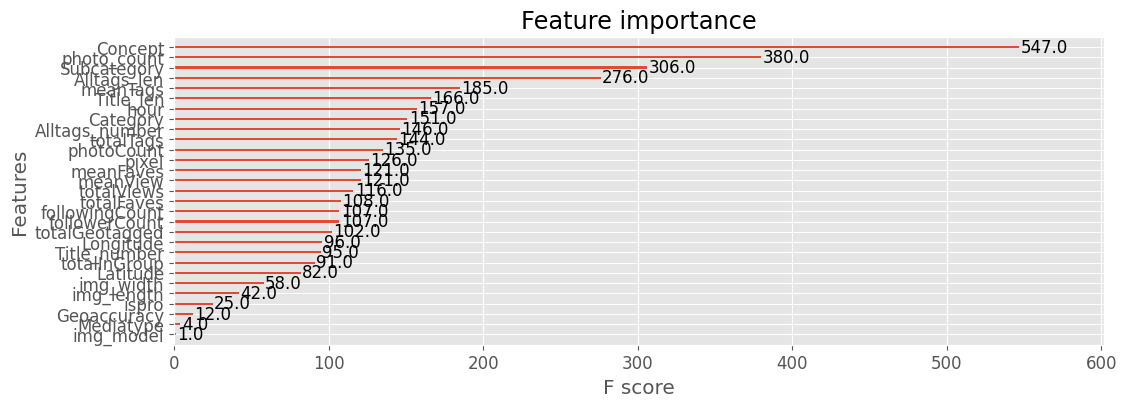

In [63]:
classifier = XGBClassifier(eval_metric='logloss',use_label_encoder=False)
classifier.fit(X, y)
fig, ax = plt.subplots(figsize=(12,4))
plot_importance(classifier, ax=ax)
plt.show();

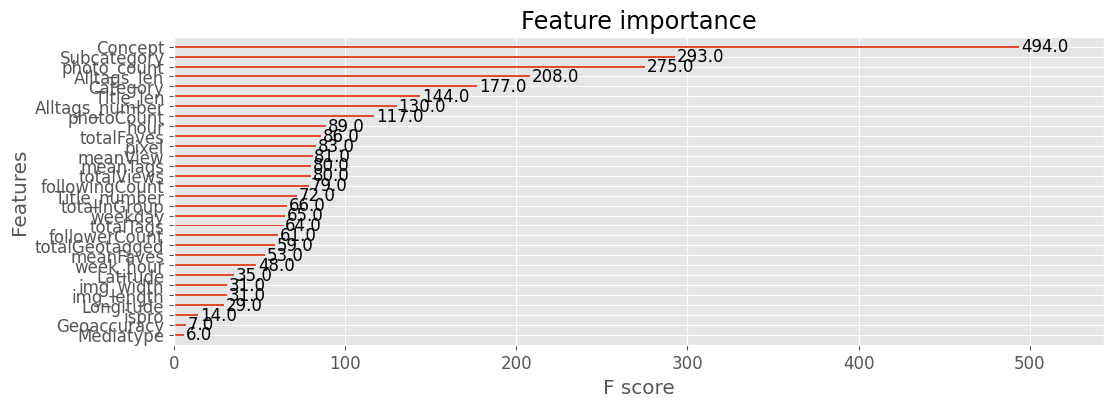

In [35]:
classifier = XGBClassifier(eval_metric='logloss',use_label_encoder=False)
classifier.fit(X, y)
fig, ax = plt.subplots(figsize=(12,4))
plot_importance(classifier, ax=ax)
plt.show();

In [64]:
X_train_wo =  X_train.drop(['AV_label'], axis=1)
X_train_new = X_train_wo.copy()
X_train_new['proba'] = classifier.predict_proba(X_train_new)[:,1]
X_train_new['target'] = y
X_train_new

,Category,Subcategory,Concept,Title_len,Title_number,Alltags_len,Alltags_number,img_length,img_width,pixel,...,totalInGroup,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount,Ispublic,proba,target
0,5,14,557,14,2,64,9,500,333,166500,...,0,0,0.000000,0.000000,0.000000,0,0,1,0.001692,0
1,2,43,317,7,1,12,2,281,500,140500,...,0,1152,30.392361,0.098090,0.000000,13,11,1,0.000290,0
2,5,62,305,11,2,440,67,500,375,187500,...,145,854,802.645199,0.779859,2.851288,233,382,1,0.004314,0
3,0,11,371,8,1,72,8,500,333,166500,...,206,83,6855.397590,4.650602,50.650602,1117,771,1,0.002825,0
4,0,16,125,48,8,109,9,500,419,209500,...,453,18784,2037.190322,0.090183,0.095081,1200,45,1,0.003293,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305608,3,21,72,29,3,214,27,500,500,250000,...,2,188,318.515957,6.351064,0.000000,2,3,1,0.035010,0
305609,10,47,39,6,1,46,7,500,352,176000,...,0,0,0.000000,0.000000,0.000000,0,0,1,0.004683,0
305610,0,6,468,13,2,226,20,500,500,250000,...,13,1174,36.131175,0.666951,0.548552,85,72,1,0.004201,0
305611,0,17,175,12,2,167,17,333,500,166500,...,64,487,6366.390144,0.667351,0.394251,634,54,1,0.002512,0


In [65]:
X_train_new['proba'].max()

0.9817085

In [66]:
nrows = X_train_new.shape[0]
# nrows = X_new.shape[0]
adversarial_validation_data = X_train_new.sort_values(by='proba',ascending=False)
# adversarial_training_data = X_new.sort_values(by='proba',ascending=False)[int(nrows*.2):]
adversarial_validation_data

,Category,Subcategory,Concept,Title_len,Title_number,Alltags_len,Alltags_number,img_length,img_width,pixel,...,totalInGroup,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount,Ispublic,proba,target
274711,1,1,448,26,5,27,4,500,375,187500,...,0,0,0.000000,0.000000,0.000000,0,0,1,0.981709,0
31777,7,74,399,5,1,139,17,500,258,129000,...,0,0,0.000000,0.000000,0.000000,0,0,1,0.860564,0
64818,3,71,607,22,4,63,8,500,327,163500,...,0,0,0.000000,0.000000,0.000000,0,0,1,0.818196,0
64830,3,71,607,22,4,48,6,500,282,141000,...,0,0,0.000000,0.000000,0.000000,0,0,1,0.765439,0
233050,2,61,554,28,4,102,12,500,333,166500,...,0,0,0.000000,0.000000,0.000000,0,0,1,0.736752,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288267,10,59,646,29,1,676,74,500,333,166500,...,2,140204,359.755784,0.027018,0.000014,1322,39,1,0.000009,0
287991,10,59,646,29,1,676,74,500,333,166500,...,2,140204,359.755784,0.027018,0.000014,1322,39,1,0.000009,0
288064,10,59,646,29,1,676,74,500,333,166500,...,2,140204,359.755784,0.027018,0.000014,1322,39,1,0.000009,0
287738,10,59,646,29,1,676,74,500,333,166500,...,2,140204,359.755784,0.027018,0.000014,1322,39,1,0.000008,0


In [67]:
adversarial_validation_data[:int(nrows*.011)]

,Category,Subcategory,Concept,Title_len,Title_number,Alltags_len,Alltags_number,img_length,img_width,pixel,...,totalInGroup,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount,Ispublic,proba,target
274711,1,1,448,26,5,27,4,500,375,187500,...,0,0,0.000000,0.000000,0.000000,0,0,1,0.981709,0
31777,7,74,399,5,1,139,17,500,258,129000,...,0,0,0.000000,0.000000,0.000000,0,0,1,0.860564,0
64818,3,71,607,22,4,63,8,500,327,163500,...,0,0,0.000000,0.000000,0.000000,0,0,1,0.818196,0
64830,3,71,607,22,4,48,6,500,282,141000,...,0,0,0.000000,0.000000,0.000000,0,0,1,0.765439,0
233050,2,61,554,28,4,102,12,500,333,166500,...,0,0,0.000000,0.000000,0.000000,0,0,1,0.736752,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93406,3,71,164,50,7,234,28,500,60,30000,...,2,5102,45.372991,1.794590,0.000000,7,1,1,0.087331,0
160550,8,46,571,15,2,34,4,268,500,134000,...,0,0,0.000000,0.000000,0.000000,0,0,1,0.087331,0
290730,6,18,414,17,1,88,13,372,500,186000,...,0,3663,9701.871144,0.156975,0.001638,2974,0,1,0.087330,0
52475,6,13,71,8,1,58,8,357,500,178500,...,0,0,0.000000,0.000000,0.000000,0,0,1,0.087287,0


In [68]:
adversarial_validation_data[adversarial_validation_data['proba'] > 0.70]

,Category,Subcategory,Concept,Title_len,Title_number,Alltags_len,Alltags_number,img_length,img_width,pixel,...,totalInGroup,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount,Ispublic,proba,target
274711,1,1,448,26,5,27,4,500,375,187500,...,0,0,0.000000,0.000000,0.0,0,0,1,0.981709,0
31777,7,74,399,5,1,139,17,500,258,129000,...,0,0,0.000000,0.000000,0.0,0,0,1,0.860564,0
64818,3,71,607,22,4,63,8,500,327,163500,...,0,0,0.000000,0.000000,0.0,0,0,1,0.818196,0
64830,3,71,607,22,4,48,6,500,282,141000,...,0,0,0.000000,0.000000,0.0,0,0,1,0.765439,0
233050,2,61,554,28,4,102,12,500,333,166500,...,0,0,0.000000,0.000000,0.0,0,0,1,0.736752,0
107211,2,61,522,1,1,88,11,500,375,187500,...,11,27338,46.193065,0.351379,0.0,34,2,1,0.700553,0


In [2]:
## 读取数据
all_data = pd.read_csv('../data/feature_data_530.csv')
# glove
glove_tags = pd.read_csv('../data/alltags_feature.csv')
glove_title = pd.read_csv('../data/title_feature.csv')
all_data = pd.concat([all_data, glove_tags, glove_title], axis=1)
# all_data = pd.concat([all_data, glove_tags, glove_title], axis=1)
# columns = ['Category', 'Uid', 'Subcategory','Mediatype', 'Longitude', 'Geoaccuracy', 'Latitude',
#          'Title_len', 'Title_number','Alltags_len','Alltags_number', 'hour', 'day','weekday','week_hour',
#           'year_weekday','photo_count', 'totalTags', 'totalGeotagged', 'totalFaves',
#           'totalInGroup','photoCount','meanView', 'meanTags', 'meanFaves', 'followerCount',
#           'followingCount']


# skew_features = all_data[columns].apply(lambda x: skew(x)).sort_values(ascending=False)

# high_skew = skew_features[skew_features > 0.75]
# skew_index = high_skew.index

# for i in skew_index:
#     all_data[i] = np.log1p(all_data[i])
    
train_all_data = all_data[all_data['train_type'] != -1]
submit_all_data = all_data[all_data['train_type'] == -1]
train_all_data = train_all_data.reset_index(drop=True)
submit_all_data = submit_all_data.reset_index(drop=True)

feature_columns = ['Pid', 'train_type', 'label', 'mean_label']
feature_columns += ['user_fe_{}'.format(i) for i in range(399)]
feature_columns += ['loc_fe_{}'.format(i) for i in range(400)]

train_label_df = train_all_data[['Pid', 'label']]
train_feature_df = train_all_data.drop(feature_columns, axis=1)

submit_label_df = submit_all_data[['Pid', 'label']]
submit_feature_df = submit_all_data.drop(feature_columns, axis=1)

print(len(train_feature_df), len(submit_feature_df))
print(len(train_label_df), len(submit_label_df))

305613 180581
305613 180581


In [5]:
columns = ['Geoaccuracy', 'Title_number','Alltags_len','Alltags_number','totalTags', 'totalGeotagged','totalFaves',
          'totalInGroup','meanView', 'meanTags','meanFaves', 'followerCount','followingCount']
           
         #   'Category', 'Uid', 'Subcategory','Mediatype', 'Longitude',  'Latitude',
         # 'Title_len',  'hour', 'day','weekday','week_hour',
         #  'year_weekday','photo_count',  'photoCount',  'label']
all_fea =all_data[columns]
train_all_fea = train_all_data[columns]
test_all_fea = submit_all_data[columns]

In [7]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
X_test  = test_all_fea.select_dtypes(include=['number']).copy()
X_train = train_all_fea.select_dtypes(include=['number']).copy()

# drop the target column from the training data
# X_train = X_train.drop(['label'], axis=1)
# X_test = X_test.drop(['label'], axis=1)
# add the train/test labels
X_train["AV_label"] = 0
X_test["AV_label"]  = 1

# make one big dataset
all_data = pd.concat([X_train, X_test], axis=0, ignore_index=True)

# shuffle
all_data_shuffled = all_data.sample(frac=1)

# create our DMatrix (the XGBoost data structure)
X = all_data_shuffled.drop(['AV_label'], axis=1)
y = all_data_shuffled['AV_label']
XGBdata = xgb.DMatrix(data=X,label=y)

# our XGBoost parameters
params = {"objective":"binary:logistic",
          "eval_metric":"logloss",
          'learning_rate': 0.05,
          'max_depth': 5, }

# perform cross validation with XGBoost
cross_val_results = cv(dtrain=XGBdata, params=params, 
                       nfold=5, metrics="auc", 
                       num_boost_round=200,early_stopping_rounds=20,
                       as_pandas=True)

# print out the final result
print((cross_val_results["test-auc-mean"]).tail(1))

199    0.773762
Name: test-auc-mean, dtype: float64


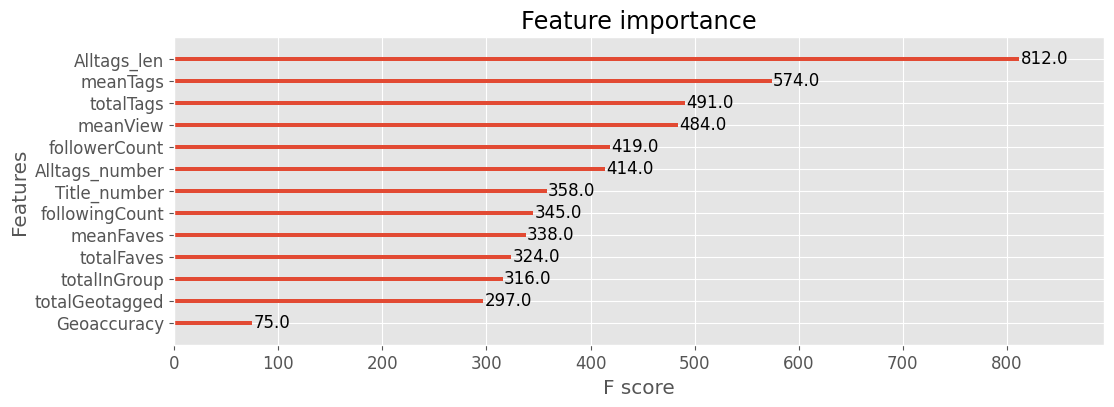

In [8]:
classifier = XGBClassifier(eval_metric='logloss',use_label_encoder=False)
classifier.fit(X, y)
fig, ax = plt.subplots(figsize=(12,4))
plot_importance(classifier, ax=ax)
plt.show();

In [10]:
X_train_wo =  X_train.drop(['AV_label'], axis=1)
X_train_new = X_train_wo.copy()
X_train_new['proba'] = classifier.predict_proba(X_train_new)[:,1]
X_train_new['target'] = y
X_train_new

,Geoaccuracy,Title_number,Alltags_len,Alltags_number,totalTags,totalGeotagged,totalFaves,totalInGroup,meanView,meanTags,meanFaves,followerCount,followingCount,proba,target
0,0,6,128,12,2215,0,904,176,4299.470263,1.531812,0.625173,2405,2729,0.313248,0
1,0,13,800,65,3991,542,6200,679,735.884072,0.052594,0.081705,8491,236,0.080475,0
2,0,2,188,23,2930,1,2583,2,5124.185756,2.820019,2.486044,1550,1346,0.240591,0
3,0,3,61,9,5707,716,76088,385,148.035342,0.046018,0.613529,1233,1115,0.442331,0
4,0,1,146,19,5344,12,0,102,5300.882729,0.579735,0.000000,5781,13,0.386843,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305608,0,1,262,35,0,0,0,0,0.000000,0.000000,0.000000,0,0,0.332916,0
305609,0,1,65,9,657,15,411,32,1085.735915,2.313380,1.447183,122,39,0.287426,0
305610,0,1,83,8,984,0,4939,202,1340.824083,0.925682,4.646284,1234,988,0.425037,0
305611,0,3,146,19,21799,56369,1291341,2882,3800.696577,1.711336,101.377061,15549,18945,0.021809,0


In [15]:
nrows = X_train_new.shape[0]
# nrows = X_new.shape[0]
adversarial_validation_data = X_train_new.sort_values(by='proba',ascending=False)
# adversarial_training_data = X_new.sort_values(by='proba',ascending=False)[int(nrows*.2):]
adversarial_validation_data

,Geoaccuracy,Title_number,Alltags_len,Alltags_number,totalTags,totalGeotagged,totalFaves,totalInGroup,meanView,meanTags,meanFaves,followerCount,followingCount,proba,target
109553,0,1,55,7,6988,1,1568,32,125.948384,0.285131,0.063979,638,400,0.943076,0
255308,0,1,472,71,196,0,152,329,20678.437094,0.031018,0.024054,8365,1798,0.941289,0
292244,0,1,472,71,196,0,152,329,20678.437094,0.031018,0.024054,8365,1798,0.941289,0
272584,15,1,32,8,0,0,0,0,0.000000,0.000000,0.000000,0,0,0.941050,0
121715,0,11,113,14,3468,647,3,5,608.290729,0.040726,0.000035,132,8,0.931338,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104381,16,23,405,36,13300,63992,8,30,1010.067841,0.184479,0.000111,807,2397,0.005134,0
104380,16,23,405,36,13300,63992,8,30,1010.067841,0.184479,0.000111,807,2397,0.005134,0
104378,16,27,405,36,13300,63992,8,30,1010.067841,0.184479,0.000111,807,2397,0.005134,0
104376,16,22,405,36,13300,63992,8,30,1010.067841,0.184479,0.000111,807,2397,0.005134,0


In [25]:
adversarial_validation_data[:int(nrows*.011)]

,Geoaccuracy,Title_number,Alltags_len,Alltags_number,totalTags,totalGeotagged,totalFaves,totalInGroup,meanView,meanTags,meanFaves,followerCount,followingCount,proba,target
109553,0,1,55,7,6988,1,1568,32,125.948384,0.285131,0.063979,638,400,0.943076,0
255308,0,1,472,71,196,0,152,329,20678.437094,0.031018,0.024054,8365,1798,0.941289,0
292244,0,1,472,71,196,0,152,329,20678.437094,0.031018,0.024054,8365,1798,0.941289,0
272584,15,1,32,8,0,0,0,0,0.000000,0.000000,0.000000,0,0,0.941050,0
121715,0,11,113,14,3468,647,3,5,608.290729,0.040726,0.000035,132,8,0.931338,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98190,0,7,110,16,1149,9,1713,35,746.288473,0.110375,0.164553,574,62,0.602914,0
289818,0,1,37,5,83,0,11,15,99.662651,1.000000,0.132530,16,17,0.602861,0
233433,16,4,62,7,18459,2371,1890,3795,410.715287,0.646754,0.066221,1415,1109,0.602773,0
109843,0,4,116,18,2663,0,58562,557,9923.247751,0.998126,21.949775,16024,2112,0.602758,0


In [26]:
adversarial_validation_data[:int(nrows*.011)].index

Int64Index([109553, 255308, 292244, 272584, 121715, 103500,  37649, 301444,
            298480, 298481,
            ...
            217988, 258203, 112481,  90948, 106953,  98190, 289818, 233433,
            109843, 242131],
           dtype='int64', length=3361)

In [28]:
adversarial_data = train_all_data.iloc[adversarial_validation_data[:int(nrows*.011)].index]
adversarial_data

,Pid,train_type,Uid,Uid_count,mean_label,Category,Subcategory,Concept,Title_len,Title_number,...,title_fe_290,title_fe_291,title_fe_292,title_fe_293,title_fe_294,title_fe_295,title_fe_296,title_fe_297,title_fe_298,title_fe_299
109553,279790,0,26151,214,0.030327,2,43,437,7,1,...,-0.385740,0.354100,-0.426820,-0.246830,-0.152080,0.305610,-0.647140,0.176130,-0.270830,-0.105880
255308,586379,1,86,101,0.522079,5,52,449,1,1,...,0.298470,0.240640,-0.155040,0.061197,0.633850,0.092940,-0.529850,0.081597,0.228840,-0.586720
292244,951731,2,86,101,0.522079,5,14,59,1,1,...,0.298470,0.240640,-0.155040,0.061197,0.633850,0.092940,-0.529850,0.081597,0.228840,-0.586720
272584,739521,1,58255,1,8.610000,6,53,568,1,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
121715,293119,0,54462,7,7.400000,0,29,666,64,11,...,-0.176601,0.323459,-0.001629,0.100555,0.297799,-0.164627,0.061319,-0.084907,-0.031626,-0.026168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98190,267372,0,17009,18,6.908889,10,47,553,31,7,...,-0.012826,-0.084601,-0.016994,-0.246137,0.002960,0.151526,-0.057907,-0.086976,-0.076376,0.114709
289818,925694,2,28408,7,3.660000,0,64,444,9,1,...,-0.309130,-0.366550,-0.278290,-0.112790,0.047074,-0.193950,0.076809,-0.301510,0.351520,0.270550
233433,440330,0,2447,3,7.913333,2,20,524,20,4,...,-0.209020,-0.041543,0.368571,0.101760,-0.053317,-0.031988,0.279620,-0.080729,0.139365,-0.104055
109843,280099,0,16060,13,7.500000,0,11,371,24,4,...,0.131560,-0.009716,-0.158162,-0.083702,0.197898,0.029387,-0.065695,0.181477,0.144789,0.159305


In [32]:
adversarial_data['label'].mean()

6.9472418922939605

In [ ]:
nrows = X_new.shape[0]
adversarial_validation_data = X_new.sort_values(by='proba',ascending=False)[:int(nrows*.2)]
adversarial_training_data = X_new.sort_values(by='proba',ascending=False)[int(nrows*.2):]

In [44]:
import pandas as pd
# mean：抽取样本20000行，允许重复抽样，随机种子选取为666，可以调整random_state来让自己的实验效果达到很好。
train_sample = train_all_fea.sample(n=50000, replace=True, random_state=2023)
test_sample = test_all_data.sample(n=50000, replace=True, random_state=2023)

In [4]:
bad_cols = []
for col in all_fea.columns:
    rate_train = all_fea[col].value_counts(normalize=True, dropna=False).values[0]
    if rate_train > 0.99:
        bad_cols.append(col)

all_fea = all_fea.drop(bad_cols, axis=1)

print('Data Shape: ', all_fea.shape)
print(bad_cols)

Data Shape:  (486194, 27)
['Mediatype']


In [45]:
train_sample = train_sample.drop(bad_cols, axis=1)
test_sample = test_sample.drop(bad_cols, axis=1)
train_sample['Is_Test'] = 0
test_sample['Is_Test'] = 1

In [6]:
train_sample = train_sample.drop(['label'], axis=1)
test_sample = test_sample.drop(['label'], axis=1)

In [66]:
!pip install xgboost

     |████████████████████████████████| 200.3 MB 20 kB/s  eta 0:00:01     |███████████████████████████▊    | 173.5 MB 7.6 MB/s eta 0:00:04


In [67]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [68]:
columns = ['Category', 'Uid', 'Subcategory','Mediatype', 'Longitude', 'Geoaccuracy', 'Latitude',
         'Title_len', 'Title_number','Alltags_len','Alltags_number', 'hour', 'day','weekday','week_hour',
          'year_weekday','photo_count', 'totalTags', 'totalGeotagged', 'totalFaves',
          'totalInGroup','photoCount','meanView', 'meanTags', 'meanFaves', 'followerCount',
          'followingCount', 'label']
all_fea =all_data[columns]
train_all_fea = train_all_data[columns]
test_all_data = submit_all_data[columns]

In [70]:
X_test  = test_all_data.select_dtypes(include=['number']).copy()
X_train = train_all_fea.select_dtypes(include=['number']).copy()

# drop the target column from the training data
X_train = X_train.drop(['label'], axis=1)
X_test = X_test.drop(['label'], axis=1)
# add the train/test labels
X_train["AV_label"] = 0
X_test["AV_label"]  = 1

# make one big dataset
all_data = pd.concat([X_train, X_test], axis=0, ignore_index=True)

# shuffle
all_data_shuffled = all_data.sample(frac=1)

# create our DMatrix (the XGBoost data structure)
X = all_data_shuffled.drop(['AV_label'], axis=1)
y = all_data_shuffled['AV_label']
XGBdata = xgb.DMatrix(data=X,label=y)

# our XGBoost parameters
params = {"objective":"binary:logistic",
          "eval_metric":"logloss",
          'learning_rate': 0.05,
          'max_depth': 5, }

# perform cross validation with XGBoost
cross_val_results = cv(dtrain=XGBdata, params=params, 
                       nfold=5, metrics="auc", 
                       num_boost_round=200,early_stopping_rounds=20,
                       as_pandas=True)

# print out the final result
print((cross_val_results["test-auc-mean"]).tail(1))

199    1.0
Name: test-auc-mean, dtype: float64


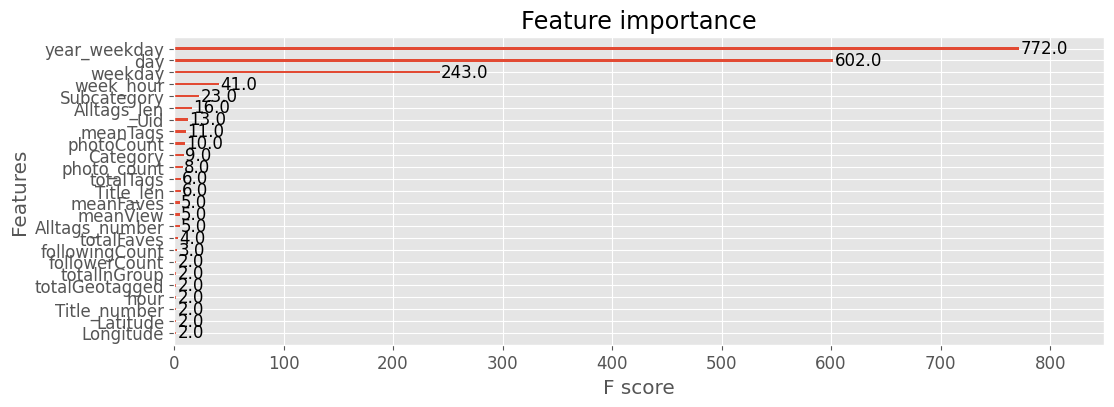

In [71]:
classifier = XGBClassifier(eval_metric='logloss',use_label_encoder=False)
classifier.fit(X, y)
fig, ax = plt.subplots(figsize=(12,4))
plot_importance(classifier, ax=ax)
plt.show();

In [72]:
##
X = X.drop(['year_weekday', 'day', 'weekday', 'week_hour'], axis=1)

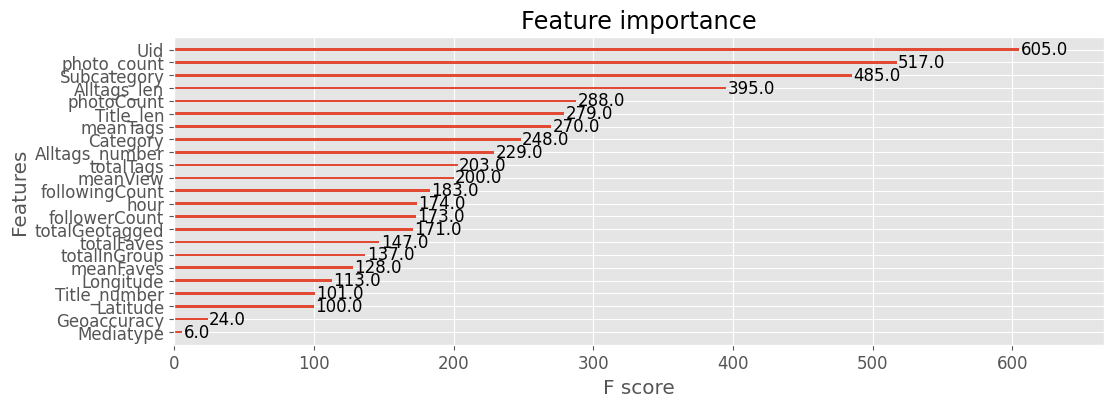

In [74]:
classifier = XGBClassifier(eval_metric='logloss',use_label_encoder=False)
classifier.fit(X, y)
fig, ax = plt.subplots(figsize=(12,4))
plot_importance(classifier, ax=ax)
plt.show();

In [73]:
XGBdata = xgb.DMatrix(data=X,label=y)
cross_val_results = cv(dtrain=XGBdata, params=params, 
                       nfold=5, metrics="auc", 
                       num_boost_round=200,early_stopping_rounds=20,
                       as_pandas=True)

print((cross_val_results["test-auc-mean"]).tail(1))

199    0.820927
Name: test-auc-mean, dtype: float64


In [77]:
X = X.drop(['Uid', 'photo_count', 'Subcategory', 'Alltags_len'], axis=1)
XGBdata = xgb.DMatrix(data=X,label=y)
cross_val_results = cv(dtrain=XGBdata, params=params, 
                       nfold=5, metrics="auc", 
                       num_boost_round=200,early_stopping_rounds=20,
                       as_pandas=True)

print((cross_val_results["test-auc-mean"]).tail(1))

199    0.772602
Name: test-auc-mean, dtype: float64


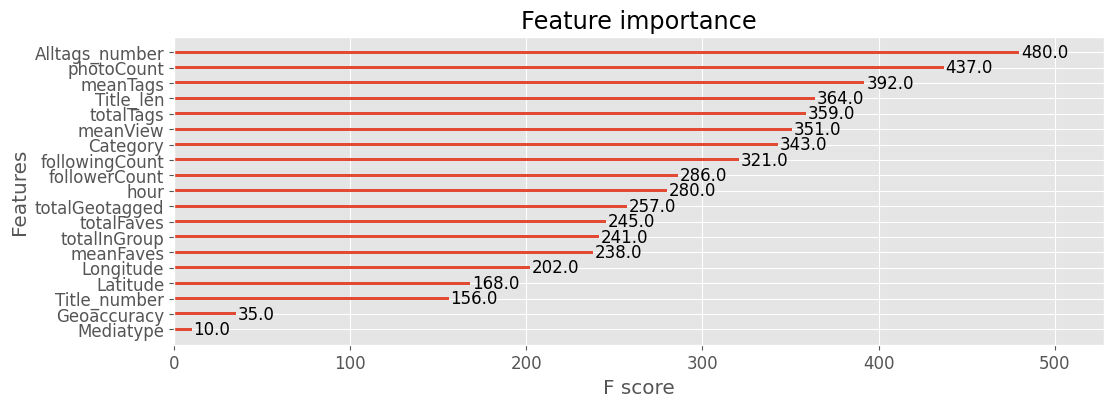

In [78]:
classifier = XGBClassifier(eval_metric='logloss',use_label_encoder=False)
classifier.fit(X, y)
fig, ax = plt.subplots(figsize=(12,4))
plot_importance(classifier, ax=ax)
plt.show();

In [79]:
X = X.drop(['Title_len', 'meanTags', 'photoCount', 'Alltags_number', 'totalTags'], axis=1)
XGBdata = xgb.DMatrix(data=X,label=y)
cross_val_results = cv(dtrain=XGBdata, params=params, 
                       nfold=5, metrics="auc", 
                       num_boost_round=200,early_stopping_rounds=20,
                       as_pandas=True)

print((cross_val_results["test-auc-mean"]).tail(1))

199    0.751417
Name: test-auc-mean, dtype: float64


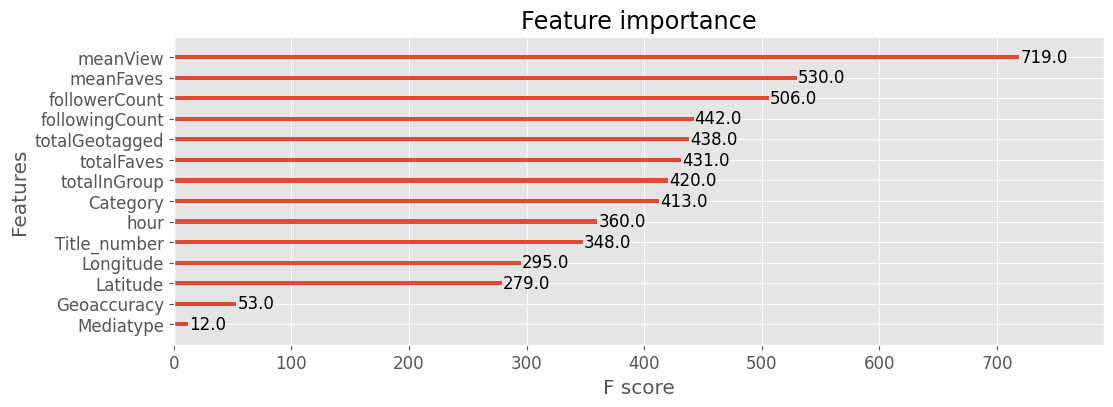

In [80]:
classifier = XGBClassifier(eval_metric='logloss',use_label_encoder=False)
classifier.fit(X, y)
fig, ax = plt.subplots(figsize=(12,4))
plot_importance(classifier, ax=ax)
plt.show();

In [81]:
X = X.drop(['meanView', 'meanFaves', 'followingCount', 'followerCount', 'totalGeotagged'], axis=1)
XGBdata = xgb.DMatrix(data=X,label=y)
cross_val_results = cv(dtrain=XGBdata, params=params, 
                       nfold=5, metrics="auc", 
                       num_boost_round=200,early_stopping_rounds=20,
                       as_pandas=True)

print((cross_val_results["test-auc-mean"]).tail(1))

199    0.712867
Name: test-auc-mean, dtype: float64


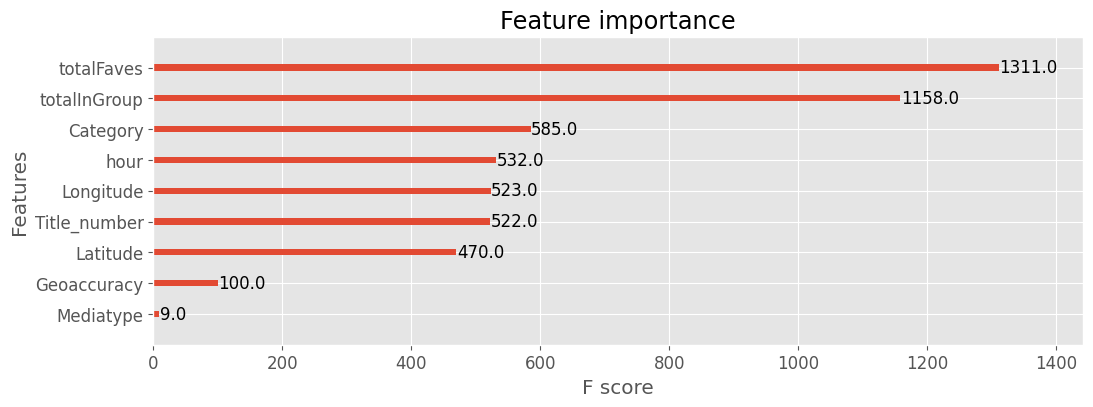

In [82]:
classifier = XGBClassifier(eval_metric='logloss',use_label_encoder=False)
classifier.fit(X, y)
fig, ax = plt.subplots(figsize=(12,4))
plot_importance(classifier, ax=ax)
plt.show();

In [75]:
from scipy import stats

features_list = X_test.columns.values.tolist()
for feature in features_list:
    statistic, p_value = stats.kstest(X_train[feature], X_test[feature])
    print("KS test value: %.3f" %statistic, "with a p-value %.2f" %p_value, "for the feature",feature)

KS test value: 0.099 with a p-value 0.00 for the feature Category
KS test value: 0.020 with a p-value 0.00 for the feature Uid
KS test value: 0.046 with a p-value 0.00 for the feature Subcategory
KS test value: 0.003 with a p-value 0.35 for the feature Mediatype
KS test value: 0.010 with a p-value 0.00 for the feature Longitude
KS test value: 0.009 with a p-value 0.00 for the feature Geoaccuracy
KS test value: 0.008 with a p-value 0.00 for the feature Latitude
KS test value: 0.011 with a p-value 0.00 for the feature Title_len
KS test value: 0.007 with a p-value 0.00 for the feature Title_number
KS test value: 0.100 with a p-value 0.00 for the feature Alltags_len
KS test value: 0.082 with a p-value 0.00 for the feature Alltags_number
KS test value: 0.022 with a p-value 0.00 for the feature hour
KS test value: 0.283 with a p-value 0.00 for the feature day
KS test value: 0.196 with a p-value 0.00 for the feature weekday
KS test value: 0.172 with a p-value 0.00 for the feature week_hour
KS

Some datasets have a very large number of features, so one could combine the KS test with a filter for more readable results. As a general guide I usually first take a much closer look at features that have a KS test value greater than 0.1 and have a p-value less than 0.05

In [ ]:
## 需要着重考虑， category, alltags_len, day, weekday, weekhour, year_weekday, 

In [64]:
# df_adv = pd.concat([train_sample, test_sample])

# adv_data = lgb.Dataset(
#     data=df_adv.drop('Is_Test', axis=1), label=df_adv.loc[:, 'Is_Test'])

# # 定义模型参数
# params = {
#     'boosting_type': 'gbdt',
#     'colsample_bytree': 1,
#     'learning_rate': 0.01,
#     'max_depth': 5,
#     'min_child_samples': 100,
#     'min_child_weight': 1,
#     'min_split_gain': 0.0,
#     'num_leaves': 20,
#     'objective': 'binary',
#     'random_state': 50,
#     'subsample': 1.0,
#     'subsample_freq': 0,
#     'metric': 'auc',
#     'num_threads': 8
# }

# # 交叉验证
# adv_cv_results = lgb.cv(
#     params,
#     adv_data,
#     num_boost_round=100000,
#     nfold=5,
#     # categorical_feature=categorical_columns,
#     early_stopping_rounds=500,
#     verbose_eval=True,
#     seed=42)

# print('交叉验证中最优的AUC为 {:.5f}，对应的标准差为{:.5f}.'.format(
#     adv_cv_results['auc-mean'][-1], adv_cv_results['auc-stdv'][-1]))

# print('模型最优的迭代次数为{}.'.format(len(adv_cv_results['auc-mean'])))

In [58]:
params['n_estimators'] = len(adv_cv_results['auc-mean'])

model_adv = lgb.LGBMClassifier(**params)
model_adv.fit(df_adv.drop('Is_Test', axis=1), df_adv.loc[:, 'Is_Test'])

# preds_train_all_fea = model_adv.predict_proba(train_all_fea.drop('Is_Test', axis=1))[:, 1]
preds_train_all_fea = model_adv.predict_proba(train_wo_label, axis=1)[:, 1]

In [60]:
np.unique(preds_train_all_fea)

array([0.49500017, 0.50499983])

In [57]:
train_wo_label = train_all_fea.drop('label', axis=1)
train_wo_label

,Category,Uid,Subcategory,Mediatype,Longitude,Geoaccuracy,Latitude,Title_len,Title_number,Alltags_len,...,totalTags,totalGeotagged,totalFaves,totalInGroup,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount
0,5,21894,65,1,0.00000,0,0.000000,33,6,128,...,2215,0,904,176,1446,4299.470263,1.531812,0.625173,2405,2729
1,0,53866,75,1,0.00000,0,0.000000,56,13,800,...,3991,542,6200,679,75883,735.884072,0.052594,0.081705,8491,236
2,3,26948,42,1,0.00000,0,0.000000,12,2,188,...,2930,1,2583,2,1039,5124.185756,2.820019,2.486044,1550,1346
3,10,355,68,1,0.00000,0,0.000000,18,3,61,...,5707,716,76088,385,124017,148.035342,0.046018,0.613529,1233,1115
4,2,315,43,1,0.00000,0,0.000000,8,1,146,...,5344,12,0,102,9218,5300.882729,0.579735,0.000000,5781,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305608,4,8689,7,1,0.00000,0,0.000000,9,1,262,...,0,0,0,0,0,0.000000,0.000000,0.000000,0,0
305609,6,7509,48,1,0.00000,0,0.000000,4,1,65,...,657,15,411,32,284,1085.735915,2.313380,1.447183,122,39
305610,0,52220,60,1,0.00000,0,0.000000,12,1,83,...,984,0,4939,202,1063,1340.824083,0.925682,4.646284,1234,988
305611,7,20298,55,1,0.00000,0,0.000000,7,3,146,...,21799,56369,1291341,2882,12738,3800.696577,1.711336,101.377061,15549,18945


In [50]:
df_adv

,Category,Uid,Subcategory,Longitude,Geoaccuracy,Latitude,Title_len,Title_number,Alltags_len,Alltags_number,...,totalFaves,totalInGroup,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount,label,Is_Test
22041,5,47818,38,0.0,0,0.0,45,10,30,5,...,2131,122,492,806.243902,0.256098,4.331301,179,228,9.81,0
178630,0,54709,60,0.0,0,0.0,15,2,89,12,...,876,110,1260,759.657143,1.481746,0.695238,1421,2295,7.57,0
182967,2,5068,33,0.0,0,0.0,22,2,261,31,...,4042,1290,34455,513.046437,1.153098,0.117312,1412,200,8.18,0
169889,3,44222,21,0.0,0,0.0,29,4,65,7,...,78,34,8956,255.198749,0.213488,0.008709,59,32,7.09,0
39427,4,34204,36,0.0,0,0.0,5,1,90,10,...,0,0,0,0.000000,0.000000,0.000000,0,0,3.81,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28943,10,15839,8,0.0,0,0.0,21,4,54,7,...,37709,178,13565,422.687136,0.217840,2.779875,851,664,0.00,1
70298,1,29913,1,0.0,0,0.0,53,3,116,12,...,23806,6,73077,233.932345,0.102084,0.325766,1261,1035,0.00,1
105767,4,54937,12,0.0,0,0.0,17,1,84,13,...,6,11,10071,8.460630,0.005759,0.000596,32,38,0.00,1
4592,6,51612,18,0.0,0,0.0,24,4,266,32,...,367,0,11046,582.958356,0.120043,0.033225,27,9,0.00,1


In [53]:
train_all_fea

,Category,Uid,Subcategory,Mediatype,Longitude,Geoaccuracy,Latitude,Title_len,Title_number,Alltags_len,...,totalGeotagged,totalFaves,totalInGroup,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount,label
0,5,21894,65,1,0.00000,0,0.000000,33,6,128,...,0,904,176,1446,4299.470263,1.531812,0.625173,2405,2729,11.18
1,0,53866,75,1,0.00000,0,0.000000,56,13,800,...,542,6200,679,75883,735.884072,0.052594,0.081705,8491,236,15.15
2,3,26948,42,1,0.00000,0,0.000000,12,2,188,...,1,2583,2,1039,5124.185756,2.820019,2.486044,1550,1346,10.99
3,10,355,68,1,0.00000,0,0.000000,18,3,61,...,716,76088,385,124017,148.035342,0.046018,0.613529,1233,1115,8.63
4,2,315,43,1,0.00000,0,0.000000,8,1,146,...,12,0,102,9218,5300.882729,0.579735,0.000000,5781,13,11.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305608,4,8689,7,1,0.00000,0,0.000000,9,1,262,...,0,0,0,0,0.000000,0.000000,0.000000,0,0,4.00
305609,6,7509,48,1,0.00000,0,0.000000,4,1,65,...,15,411,32,284,1085.735915,2.313380,1.447183,122,39,1.00
305610,0,52220,60,1,0.00000,0,0.000000,12,1,83,...,0,4939,202,1063,1340.824083,0.925682,4.646284,1234,988,2.00
305611,7,20298,55,1,0.00000,0,0.000000,7,3,146,...,56369,1291341,2882,12738,3800.696577,1.711336,101.377061,15549,18945,6.89


In [36]:
preds_train_all_fea

array([1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15])

In [37]:
import numpy as np
np.unique(preds_train_all_fea)

array([1.e-15])

In [38]:
pd.DataFrame(preds_train_all_fea).describe()

,0
count,3.056130e+05
mean,1.000000e-15
std,0.000000e+00
min,1.000000e-15
25%,1.000000e-15
50%,1.000000e-15
75%,1.000000e-15
max,1.000000e-15


In [11]:
len(preds_adv)

486194

In [ ]:
## 选择出和测试集最接近的作为验证集


In [ ]:
def run_cv(df_train, sample_weight=None):
    if sample_weight is not None:
        train_set = lgb.Dataset(
            train_all_fea.drop('HasDetections', axis=1),
            label=train_all_fea.loc[:, 'HasDetections'], weight=sample_weight)

    else:
        train_set = lgb.Dataset(
            train_all_fea.drop('HasDetections', axis=1),
            label=train_all_fea.loc[:, 'HasDetections'])

    # Perform cross validation with early stopping
    params.pop('n_estimators', None)
    
    N_FOLDS = 5
    cv_results = lgb.cv(
        params,
        train_set,
        num_boost_round=100000,
        nfold=N_FOLDS,
        # categorical_feature=categorical_columns,
        early_stopping_rounds=500,
        verbose_eval=True,
        seed=42)

    print('交叉验证中最优的AUC为 {:.5f}，对应的标准差为{:.5f}.'.format(
        cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))

    print('模型最优的迭代次数为{}.'.format(len(cv_results['auc-mean'])))

    params['n_estimators'] = len(cv_results['auc-mean'])

    model_cv = lgb.LGBMClassifier(**params)
    model_cv.fit(df_train.drop('HasDetections', axis=1),
                 df_train.loc[:, 'HasDetections'])

    # AUC
    preds_test_cv = model_cv.predict_proba(
        df_test.drop('HasDetections', axis=1))[:, 1]
    auc_test_cv = roc_auc_score(df_test.loc[:, 'HasDetections'], preds_test_cv)
    print('模型在测试集上的效果是{:.5f}。'.format(
        auc_test_cv))

    return model_cv